In [1]:
import sys
sys.path.insert(0, r'../../quetzal/')
from syspy.syspy_utils import neighbors

import pandas as pd 
import geopandas as gpd
ipath = r'../inputs/'
dpath = r'data/'

SQLalchemy is not installed. No support for SQL output.


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 15)

In [3]:
# load basemaps
import rasterio
from rasterio import plot as _
raster_light = rasterio.open(dpath + r'raster_light.tiff')
raster_dark = rasterio.open(dpath + r'raster_dark.tiff')

# Read station data

Create station geodataframe

In [4]:
df = pd.read_csv(dpath + r'stations.csv', index_col=0)

In [5]:
from shapely.geometry import Point

df['geometry'] = df['geo_point_2d'].apply(
    lambda x : Point([float(a) for a in x.split(',')][::-1])
)
gdf_4326 = gpd.GeoDataFrame(df)
gdf_4326.crs = {'init': 'epsg:4326'}
stations = gdf_4326.to_crs(epsg=2154)

# Read vehicle data

Create vehicle geodataframe

In [6]:
vehicles = pd.read_csv(dpath + r'vehicles.csv', index_col=0)
vehicles['geometry'] = vehicles['loc'].apply(lambda x: Point([float(c) for c in x.split(',')[::-1]]))

vehicles = gpd.GeoDataFrame(vehicles)
vehicles.crs = {'init': 'epsg:4326'}
vehicles = vehicles.to_crs(epsg=2154)

Filter vehicle outside the stations area

In [7]:
from shapely.geometry import MultiPoint
perimeter = MultiPoint(stations.geometry).convex_hull.buffer(100)

<AxesSubplot:>

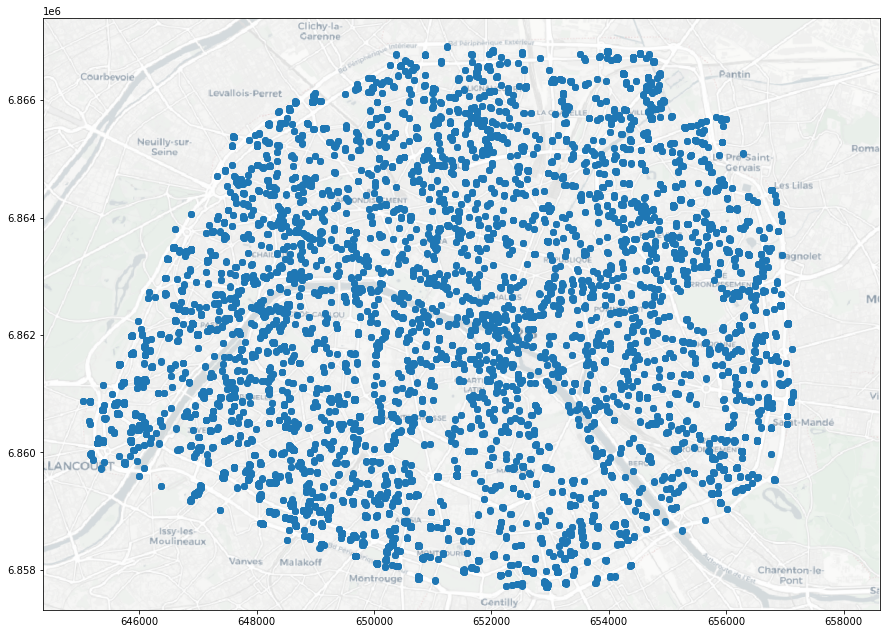

In [8]:
vehicles = vehicles.loc[vehicles.within(perimeter)]
ax = vehicles.plot()
rasterio.plot.show(raster_light, ax=ax)

In [9]:
print(len(vehicles), len(stations))

17289 2455


# Assign each vehicle to the nearest station

In [10]:
vehicles['station_id'] = neighbors.nearest(vehicles, stations).set_index('ix_one')['ix_many']

# Compute the number of vehicle by station

In [11]:
stations['n_vehicles'] = vehicles.groupby('station_id')['loc'].count()
stations['n_vehicles'] = stations['n_vehicles'].fillna(0)

In [12]:
stations['n_vehicles'].describe()

count    2455.000000
mean        7.042363
std         9.067967
min         0.000000
25%         0.000000
50%         3.000000
75%         9.000000
max        75.000000
Name: n_vehicles, dtype: float64

<AxesSubplot:>

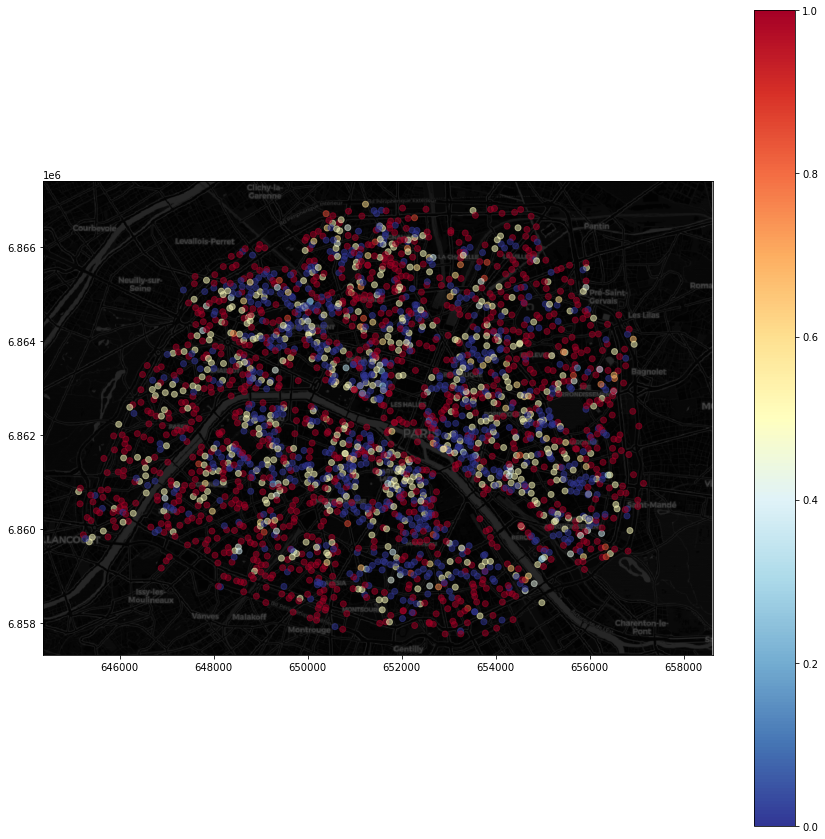

In [13]:
stations['saturation'] = stations['n_vehicles']  / stations['capacity']
ax = stations.plot('saturation', cmap='RdYlBu_r', legend=True, vmin=0, vmax=1, alpha=0.5)
rasterio.plot.show(raster_dark, ax=ax)

# Aggregate stations by clusters

In [14]:
from syspy.spatial import spatial
stations['cluster_id'] = spatial.agglomerative_clustering(
    stations,
    distance_threshold=1000
)

In [15]:
macro_stations = stations.dissolve('cluster_id', aggfunc=sum)

In [16]:
macro_stations.geometry = macro_stations.convex_hull

In [17]:
macro_stations['saturation'] = macro_stations['n_vehicles']  / macro_stations['capacity']

In [18]:
macro_stations['saturation'].describe()

count    252.000000
mean       1.318042
std        0.973183
min        0.057692
25%        0.633247
50%        0.989796
75%        1.730821
max        6.833333
Name: saturation, dtype: float64

<AxesSubplot:>

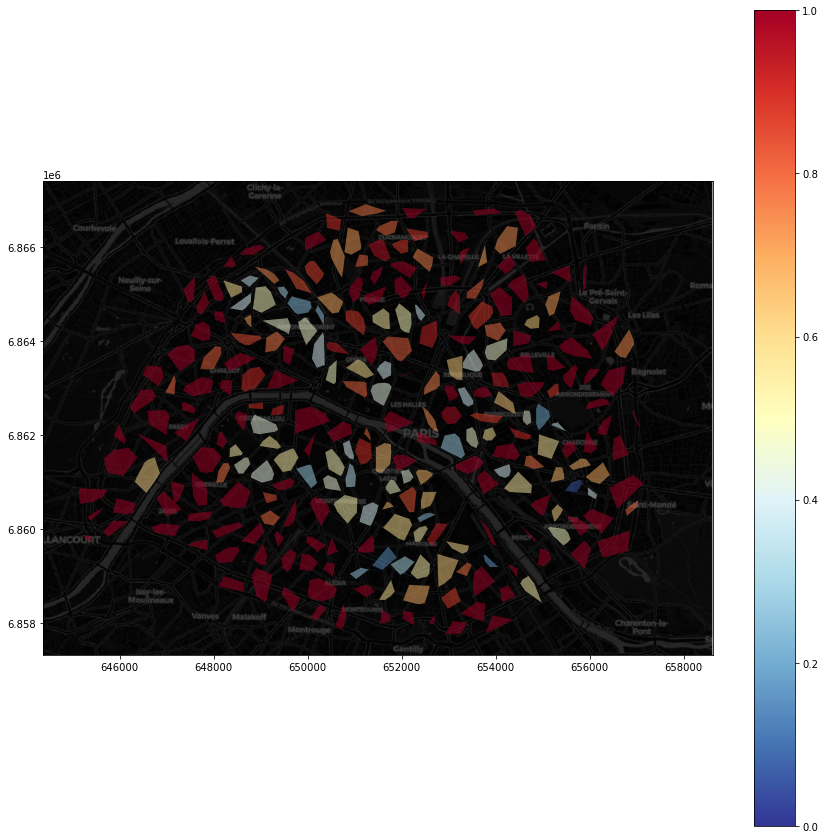

In [19]:
ax = macro_stations.plot('saturation', cmap='RdYlBu_r', legend=True, vmin=0, vmax=1, alpha=0.5)
rasterio.plot.show(raster_dark, ax=ax)